# Baseline 2-Staged Least Squares Instrumental Variables Regression using Cornelia's Randomized Medical Data

- Using year, month, county as fixed effects. But interact year_trend * month_county.
- Include control diagnoses.

In [1]:
# optional. I'm getting annoying warnings that I just want to ignore:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# basics
import pandas as pd 
import numpy as np
import os 
import re
from datetime import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import requests
import urllib

# plotting
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import plotly.express as px
import seaborn as sns

# modeling
from patsy import dmatrices
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.sandbox.regression.gmm import IV2SLS

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [2]:
# download this extra package from here: https://github.com/bashtage/linearmodels
#!pip install linearmodels
# from linearmodels.iv import IV2SLS as IV2SLS_v2

In [3]:
# local or gdrive
path_source = 'anandlocal'

if path_source == 'gdrive':
  from google.colab import drive
  drive.mount('/content/gdrive')
  data_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/content/gdrive/MyDrive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'
  
elif path_source == 'local':
  data_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/tj/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'work':
  data_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/Data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

elif path_source == 'anandlocal':
  data_path = 'data'
  fitted_models_path = '/Users/trevorjohnson/trevorj@berkeley.edu - Google Drive/My Drive/Classes/W210_capstone/W210_Capstone/fitted_models/2022-10-23'

  def current_path():
    print("Current working directory before")
    print(os.getcwd())
    print()
  current_path()
  os.chdir('../../')
  current_path()

Current working directory before
c:\Users\anandadmin\Documents\ML_MS\UCB\2022_Fall\W210\JLPS_capstone_project\modeling\anand_backup

Current working directory before
c:\Users\anandadmin\Documents\ML_MS\UCB\2022_Fall\W210\JLPS_capstone_project



In [4]:
# decide whether to save results:
save_results = False

# Read in data

In [5]:
if path_source == 'anandlocal':
    # on anand's local set up...
    # read in our modeling data
    df = pd.read_csv(data_path + '//' + 'modeling_data//modeling_data_2022-10-18.csv')

    # read in cornelia's healthcare data
    df1 = pd.read_csv(data_path + '//' + 'medical//hematopoietic_cancers.csv').iloc[:,1:]
    df2 = pd.read_csv(data_path + '//' + 'medical//pediatric_vasculitis.csv').iloc[:,1:]
    df3 = pd.read_csv(data_path + '//' + 'medical//type_1_diabetes.csv').iloc[:,1:]
    df4 = pd.read_csv(data_path + '//' + 'medical//resp_cardio.csv').iloc[:,1:]
    df5 = pd.read_csv(data_path + '//' + 'medical//injuries_accidents.csv').iloc[:,1:]
else:
    # read in our modeling data
    df = pd.read_csv(os.path.join(data_path, 'modeling_data/modeling_data_2022-10-18.csv'))

    # read in cornelia's healthcare data
    df1 = pd.read_csv(os.path.join(data_path, 'medical/hematopoietic_cancers.csv')).iloc[:,1:]
    df2 = pd.read_csv(os.path.join(data_path, 'medical/pediatric_vasculitis.csv')).iloc[:,1:]
    df3 = pd.read_csv(os.path.join(data_path, 'medical/type_1_diabetes.csv')).iloc[:,1:]
    df4 = pd.read_csv(os.path.join(data_path, 'medical/resp_cardio.csv')).iloc[:,1:]
    df5 = pd.read_csv(os.path.join(data_path, 'medical/injuries_accidents.csv')).iloc[:,1:]

In [6]:
df[['avg_wind_alignment', 'avg_wind_alignment_cosine']].head(3)

,avg_wind_alignment,avg_wind_alignment_cosine
0,82.561735,1.124995
1,97.028283,0.879819
2,103.664653,0.869845


In [7]:
# check if rolling columns are already there for pm25
df[['year_month', 'school_zip', 'pm25', 'pm25_last_month','pm25_r6','pm25_r9','pm25_r12','pm25_r24']][df.school_zip == 90001].head(25)

,year_month,school_zip,pm25,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24
0,2000-01-01,90001,32.149998,NaN,NaN,NaN,NaN,NaN
1322,2000-02-01,90001,13.666667,32.149998,NaN,NaN,NaN,NaN
2644,2000-03-01,90001,17.183334,13.666667,NaN,NaN,NaN,NaN
3966,2000-04-01,90001,17.366667,17.183334,NaN,NaN,NaN,NaN
5288,2000-05-01,90001,17.616667,17.366667,NaN,NaN,NaN,NaN
6611,2000-06-01,90001,16.883333,17.616667,NaN,NaN,NaN,NaN
7934,2000-07-01,90001,18.850000,16.883333,19.144444,NaN,NaN,NaN
9258,2000-08-01,90001,18.833332,18.850000,16.927778,NaN,NaN,NaN
10582,2000-09-01,90001,17.766666,18.833332,17.788889,NaN,NaN,NaN
11906,2000-10-01,90001,23.466667,17.766666,17.886111,18.924074,NaN,NaN


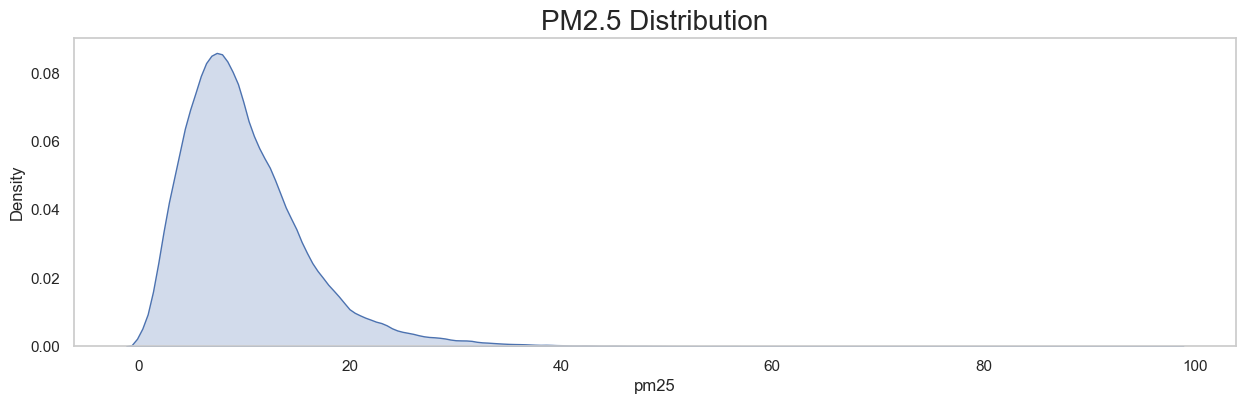

In [8]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

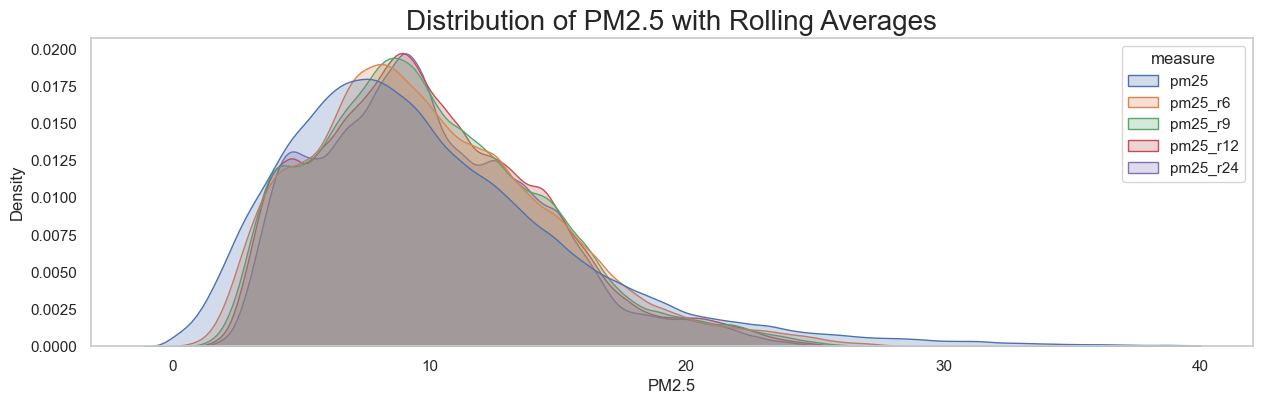

In [9]:
def kde_multiple_plotter(col_list:list, title_str:str, value_name_str:str, df_plot, clip_tuple:tuple = None):
    """plots several KDE plots from column of a dataframe.

    Args:
        col_list (list): list of columns to plot, must be in df_plot
        title_str (str): title of plot
        value_name_str (str): x axis value name
        df_plot (pandas dataframe): dataframe
        clip_tuple (tuple, optional): range of x axis values to plot. Defaults to None.
    """
    df_melt = pd.melt(df_plot, 
              value_vars=col_list, 
              var_name='measure', value_name=value_name_str)
    sns.set(rc = {'figure.figsize':(15,4)}) 
    sns.set_style("whitegrid", {'axes.grid' : False})

    sns.kdeplot(data=df_melt, x=value_name_str, hue='measure', bw_adjust=.8, fill=True, clip=clip_tuple)\
    .set_title(title_str, size=20)
    print('')

rolling_pm25_cols = ['pm25', 'pm25_r6','pm25_r9','pm25_r12','pm25_r24']
title_str = 'Distribution of PM2.5 with Rolling Averages'
name_str = 'PM2.5'
clip_tuple_val=(-5, 40.0)

kde_multiple_plotter(col_list = rolling_pm25_cols, title_str = title_str, value_name_str = name_str, df_plot=df, clip_tuple=clip_tuple_val)

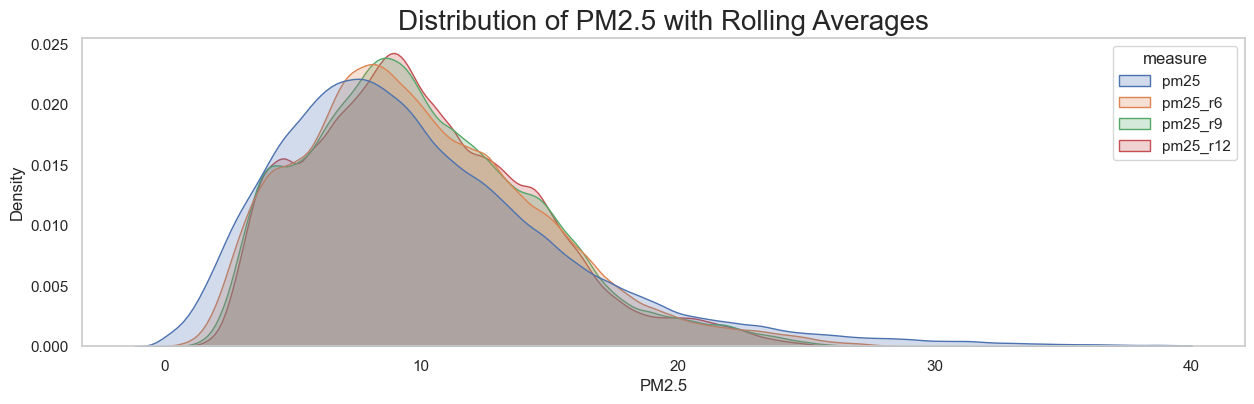

In [10]:
rolling_pm25_cols = ['pm25', 'pm25_r6','pm25_r9','pm25_r12']
title_str = 'Distribution of PM2.5 with Rolling Averages'
name_str = 'PM2.5'
clip_tuple_val=(-5, 40.0)

kde_multiple_plotter(col_list = rolling_pm25_cols, title_str = title_str, value_name_str = name_str, df_plot=df, clip_tuple=clip_tuple_val)

# Data clean

Create Rolling Features for Stage 1 Regression:

- `'pm25'`: last month, average of past 6 months, 9months, 12 months
    - already made above as `'pm25_last_month','pm25_r6','pm25_r9','pm25_r12'`
- `'avg_wind_alignment'`: last month, average of past 6 months, 9 months, 12 months
- `'avg_wind_alignment_cosine'` (transforming `avg_wind_alignment`): last month, average of past 6 months, 9 months, 12 months

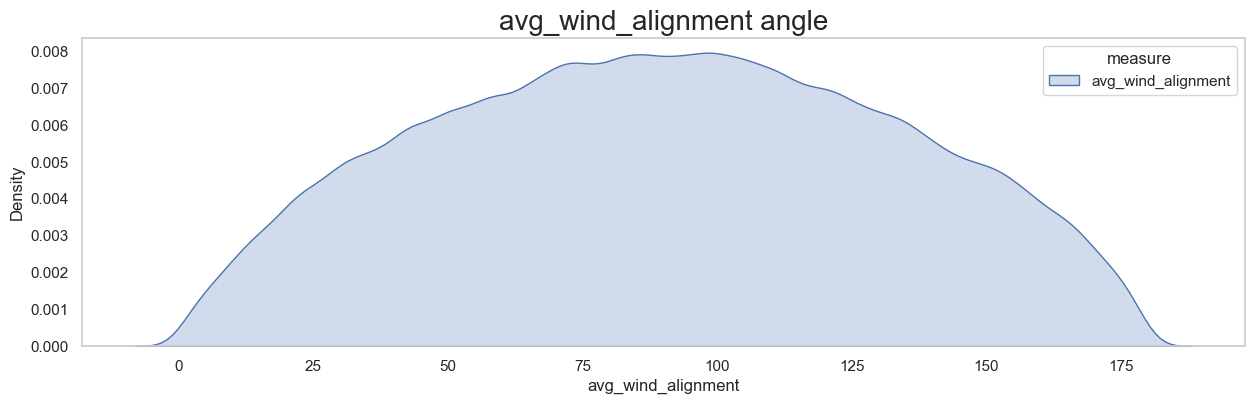

In [11]:
# avg_wind_alignment

kde_multiple_plotter(col_list = ['avg_wind_alignment'], title_str = 'avg_wind_alignment angle', value_name_str = 'avg_wind_alignment', df_plot=df)

In [13]:
df.isna().sum()

year_month                              0
school_zip                              0
school_county_v2                        0
school_region_name                      0
pm25                                    0
school_elevation_m                      0
ps_elevation_m                          0
population_0_4                          0
population_0_4_male                     0
population_0_4_female                   0
population_5_9                          0
population_5_9_male                     0
population_5_9_female                   0
population_10_14                        0
population_10_14_male                   0
population_10_14_female                 0
population_15_19                        0
population_15_19_male                   0
population_15_19_female                 0
total_pop_under19                       0
pop_under19_male                        0
pop_under19_female                      0
total_population                        0
total_population_male             

In [20]:
# Sort the dataframe by school zip and year_month ascending so we can use rolling values in order of year_month

# convert to date time object
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df = df.sort_values(['school_zip', 'year_month'])

df.head(5)

,year_month,school_zip,school_county_v2,school_region_name,pm25,school_elevation_m,ps_elevation_m,population_0_4,population_0_4_male,population_0_4_female,population_5_9,population_5_9_male,population_5_9_female,population_10_14,population_10_14_male,population_10_14_female,population_15_19,population_15_19_male,population_15_19_female,total_pop_under19,pop_under19_male,pop_under19_female,total_population,total_population_male,total_population_female,point_source_pm25_tpy,dist_school_to_ps_m,angle_to_school,ps_wspd_merge,school_wdir_wrt_0n,ps_wdir_wrt_0n,school_wind_alignment,ps_wind_alignment,avg_wind_speed,avg_wind_alignment,avg_wind_alignment_cosine,nearby_point_source_count,school_wspd,ca_agi_per_returns,total_tax_liability,tax_liability_per_capita,school_temperature,ps_temperature,school_count,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,pm25_r24,pm25_slope6,pm25_slope9,pm25_slope12,pm25_slope24,pm25_lag_12mo,year,month,school_county_v2_alameda,school_county_v2_alpine,school_county_v2_amador,school_county_v2_butte,school_county_v2_calaveras,school_county_v2_colusa,school_county_v2_contra_costa,school_county_v2_del_norte,school_county_v2_el_dorado,school_county_v2_fresno,school_county_v2_glenn,school_county_v2_humboldt,school_county_v2_imperial,school_county_v2_inyo,school_county_v2_kern,school_county_v2_kings,school_county_v2_lake,school_county_v2_lassen,school_county_v2_los_angeles,school_county_v2_madera,school_county_v2_marin,school_county_v2_mariposa,school_county_v2_mendocino,school_county_v2_merced,school_county_v2_modoc,school_county_v2_mono,school_county_v2_monterey,school_county_v2_napa,school_county_v2_nevada,school_county_v2_orange,school_county_v2_placer,school_county_v2_plumas,school_county_v2_riverside,school_county_v2_sacramento,school_county_v2_san_benito,school_county_v2_san_bernardino,school_county_v2_san_diego,school_county_v2_san_francisco,school_county_v2_san_joaquin,school_county_v2_san_luis_obispo,school_county_v2_san_mateo,school_county_v2_santa_barbara,school_county_v2_santa_clara,school_county_v2_santa_cruz,school_county_v2_shasta,school_county_v2_sierra,school_county_v2_siskiyou,school_county_v2_solano,school_county_v2_sonoma,school_county_v2_stanislaus,school_county_v2_sutter,school_county_v2_tehama,school_county_v2_trinity,school_county_v2_tulare,school_county_v2_tuolumne,school_county_v2_ventura,school_county_v2_yolo,school_county_v2_yuba,month_01,month_02,month_03,month_04,month_05,month_06,month_07,month_08,month_09,month_10,month_11,month_12
0,2000-01-01,90001,Los Angeles,Los Angeles County,32.149998,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.757031,-172.758321,-172.758321,82.561735,82.561735,0.757031,82.561735,1.124995,0.0,0.757031,20049.704556,2608176.0,47.87313,14.277778,14.266667,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1322,2000-02-01,90001,Los Angeles,Los Angeles County,13.666667,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.965276,30.294778,30.294778,120.491364,120.491364,0.965276,120.491364,0.547186,0.0,0.965276,20049.704556,2608176.0,47.87313,13.877778,13.866667,9,32.149998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2644,2000-03-01,90001,Los Angeles,Los Angeles County,17.183334,44.728889,43.703333,6196.0,3209.0,2987.0,6672.0,3397.0,3275.0,5562.0,2850.0,2712.0,5075.0,2599.0,2476.0,23505.0,12055.0,11450.0,54481.0,27320.0,27161.0,14.241154,3854.812685,-90.196586,0.199593,107.246620,107.246620,147.368213,147.368213,0.199593,14

In [22]:
type(df.year_month[0])

pandas._libs.tslibs.timestamps.Timestamp

In [23]:

# get rolling n month avg
def create_rolling_avg(df, var_name:str = 'pm25', num_months=6):
  """create rolling average of a variable for a number of months specified. Closed on current, so the current month is NOT included.

  Make sure that dataframe is sorted by school zipcode and year_month before running this.
  df = df.sort_values(['school_zip', 'year_month'])


  Args:
      df (_type_): dataframe to add columns to
      var_name (str, optional): column name to make rolling average of. Defaults to 'pm25'.
      num_months (int, optional): number of months to take average of. done using . Defaults to 6.

  Returns:
      _type_: _description_
  """
  df[f'{var_name}_r{num_months}'] = df.groupby('school_zip')[var_name]\
    .apply(lambda x: x.rolling(window=num_months, min_periods=num_months, closed='left').mean())
    
  return df 

In [29]:
# last month's avg_wind_alignment

df = create_rolling_avg(df, var_name='avg_wind_alignment', num_months=1)
df = create_rolling_avg(df, var_name='avg_wind_alignment', num_months=6)
df = create_rolling_avg(df, var_name='avg_wind_alignment', num_months=9)
df = create_rolling_avg(df, var_name='avg_wind_alignment', num_months=12)

In [31]:
show_cols = ['year_month', 'school_zip', 'pm25', 'pm25_last_month', 'pm25_r6','pm25_r9','pm25_r12','avg_wind_alignment', 'avg_wind_alignment_r1', 'avg_wind_alignment_r6', 'avg_wind_alignment_r9', 'avg_wind_alignment_r12']

df[show_cols].head(20)


,year_month,school_zip,pm25,pm25_last_month,pm25_r6,pm25_r9,pm25_r12,avg_wind_alignment,avg_wind_alignment_r1,avg_wind_alignment_r6,avg_wind_alignment_r9,avg_wind_alignment_r12
0,2000-01-01,90001,32.149998,NaN,NaN,NaN,NaN,82.561735,NaN,NaN,NaN,NaN
1322,2000-02-01,90001,13.666667,32.149998,NaN,NaN,NaN,120.491364,82.561735,NaN,NaN,NaN
2644,2000-03-01,90001,17.183334,13.666667,NaN,NaN,NaN,147.368213,120.491364,NaN,NaN,NaN
3966,2000-04-01,90001,17.366667,17.183334,NaN,NaN,NaN,155.392932,147.368213,NaN,NaN,NaN
5288,2000-05-01,90001,17.616667,17.366667,NaN,NaN,NaN,155.432299,155.392932,NaN,NaN,NaN
6611,2000-06-01,90001,16.883333,17.616667,NaN,NaN,NaN,127.436446,155.432299,NaN,NaN,NaN
7934,2000-07-01,90001,18.850000,16.883333,19.144444,NaN,NaN,138.959608,127.436446,131.447165,NaN,NaN
9258,2000-08-01,90001,18.833332,18.850000,16.927778,NaN,NaN,133.562059,138.959608,140.846810,NaN,NaN
10582,2000-09-01,90001,17.766666,18.833332,17.788889,NaN,NaN,127.673332,133.562059,143.025260,NaN,NaN
11906,2000-10-01,90001,23.466667,17.766666,17.886111,18.924074,NaN,153.371510,127.673332,139.742780,132.097554,NaN


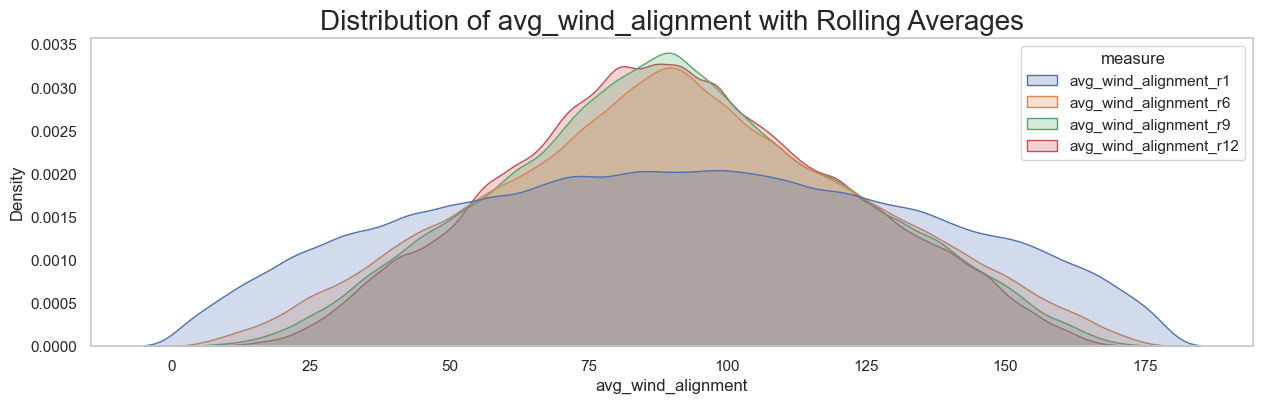

In [33]:
rolling_avg_wind_alignment_cols = ['avg_wind_alignment_r1', 'avg_wind_alignment_r6', 'avg_wind_alignment_r9', 'avg_wind_alignment_r12']
title_str = 'Distribution of avg_wind_alignment with Rolling Averages'
name_str = 'avg_wind_alignment'
clip_tuple_val=(-5, 185)

kde_multiple_plotter(col_list = rolling_avg_wind_alignment_cols, title_str = title_str, value_name_str = name_str, df_plot=df, clip_tuple=clip_tuple_val)

In [24]:
type(df.year_month[0])

pandas._libs.tslibs.timestamps.Timestamp

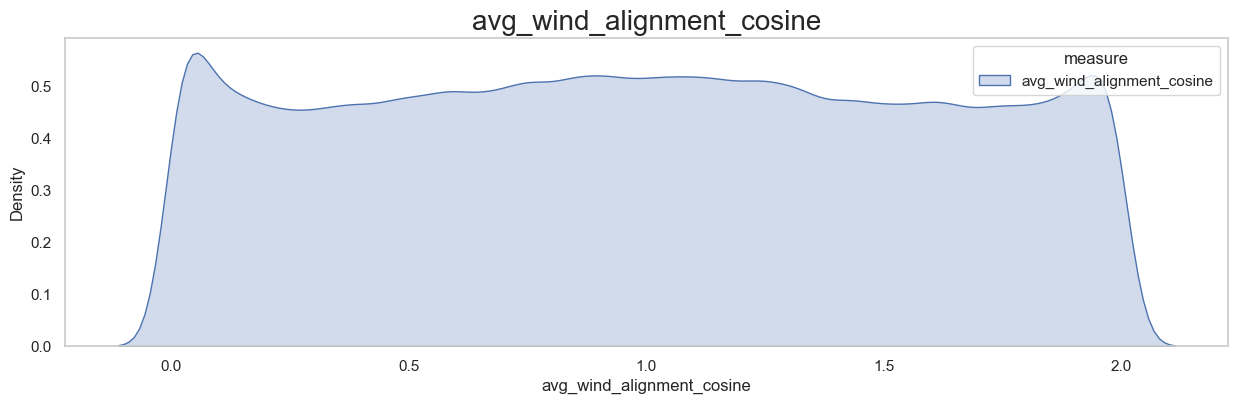

In [12]:
kde_multiple_plotter(col_list = ['avg_wind_alignment_cosine'], title_str = 'avg_wind_alignment_cosine', value_name_str = 'avg_wind_alignment_cosine', df_plot=df)

In [55]:
temp = 179.99

round(np.cos(np.radians(temp)) + 1, 6)

0.0

In [56]:
def cos_convert_multiple(row):
    def calc_cos(n):
        return round(np.cos(np.radians(n)) + 1, 6)

    return [calc_cos(row['avg_wind_alignment_r1']), calc_cos(row['avg_wind_alignment_r6']), calc_cos(row['avg_wind_alignment_r9']), calc_cos(row['avg_wind_alignment_r12'])]

In [58]:
temp = df.apply(cos_convert_multiple, axis=1, result_type='expand')

In [61]:
temp.head(20)

,0,1,2,3
0,NaN,NaN,NaN,NaN
1322,1.129458,NaN,NaN,NaN
2644,0.492592,NaN,NaN,NaN
3966,0.157847,NaN,NaN,NaN
5288,0.090815,NaN,NaN,NaN
6611,0.090529,NaN,NaN,NaN
7934,0.392119,0.338071,NaN,NaN
9258,0.245753,0.224539,NaN,NaN
10582,0.310860,0.201099,NaN,NaN
11906,0.388841,0.236849,0.329605,NaN


In [64]:
temp.columns
d = {
    0: 'avg_wind_alignment_cosine_r1',
    1: 'avg_wind_alignment_cosine_r6',
    2: 'avg_wind_alignment_cosine_r9',
    3: 'avg_wind_alignment_cosine_r12'
}
temp.rename(columns=d, inplace=True)
temp.head(13)

,avg_wind_alignment_cosine_r1,avg_wind_alignment_cosine_r6,avg_wind_alignment_cosine_r9,avg_wind_alignment_cosine_r12
0,NaN,NaN,NaN,NaN
1322,1.129458,NaN,NaN,NaN
2644,0.492592,NaN,NaN,NaN
3966,0.157847,NaN,NaN,NaN
5288,0.090815,NaN,NaN,NaN
6611,0.090529,NaN,NaN,NaN
7934,0.392119,0.338071,NaN,NaN
9258,0.245753,0.224539,NaN,NaN
10582,0.310860,0.201099,NaN,NaN
11906,0.388841,0.236849,0.329605,NaN


Clean the medical data

In [6]:
# med data:

# get all distinct patzip_year_month
all_pats = df1['patzip_year_month'].to_list() + \
  df2['patzip_year_month'].to_list() + \
  df3['patzip_year_month'].to_list() + \
  df4['patzip_year_month'].to_list() + \
  df5['patzip_year_month'].to_list() 
all_pats = list(set(all_pats))
df_med = pd.DataFrame({'patzip_year_month': all_pats})

# rename columns more intuitively
df1 = df1.rename(columns={'number_of_visits': 'number_of_visits_hem_cancers'})
df2 = df2.rename(columns={'number_of_visits': 'number_of_visits_vasc'})
df3 = df3.rename(columns={'number_of_visits': 'number_of_visits_diab'})
df4 = df4.rename(columns={'number_of_visits': 'number_of_visits_resp_cardio'})
df5 = df5.rename(columns={'number_of_visits': 'number_of_visits_injuries'})

# now join all the diagnoses on this dataset
df_med = df_med\
  .merge(df1, on='patzip_year_month', how='left')\
  .merge(df2, on='patzip_year_month', how='left')\
  .merge(df3, on='patzip_year_month', how='left')\
  .merge(df4, on='patzip_year_month', how='left')\
  .merge(df5, on='patzip_year_month', how='left')

# join data
df['year_month'] = df['year_month'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

df['zip_year_month'] = df['school_zip'].astype(str) + '-' +\
  df['year_month'].dt.year.astype(str) + '-' +\
  df['year_month'].dt.month.astype(str)

df = pd.merge(df, df_med, left_on='zip_year_month', right_on='patzip_year_month', how='left')

# for missing med data, assume there were 0 cases:
med_vars = ['hematopoietic_cancers', 'number_of_visits_hem_cancers', 
  'pediatric_vasculitis', 'number_of_visits_vasc', 
  'type_1_diabetes', 'number_of_visits_diab',
  'resp_cardio', 'number_of_visits_resp_cardio',
  'injuries_accidents', 'number_of_visits_injuries'
  ]
for var in med_vars:
  df[var] = df[var].fillna(0)

# fixing month datatype
df['month'] = df['month'].astype(str)

# Create response variables, which is visits / population
df['y_hematopoietic'] = 1000 * df['number_of_visits_hem_cancers'] / df['total_pop_under19']
df['y_vasculitis'] = 1000 * df['number_of_visits_vasc'] / df['total_pop_under19']
df['y_diabetes'] = 1000 * df['number_of_visits_diab'] / df['total_pop_under19']
df['y_resp_cardio'] = 1000 * df['number_of_visits_resp_cardio'] / df['total_pop_under19']
df['y_injuries'] = 1000 * df['number_of_visits_injuries'] / df['total_pop_under19']

# Make treatment var normally distributed by taking log(1+x)
df['pm25_log'] = np.log1p(df['pm25'])

# create year trend feature
df['year_trend'] = df['year'] - 1999

# create county_month
df['county_month'] = df.apply(lambda df: df['month'].rjust(2, '0') + '_' + df['school_county_v2'], axis=1)

# create year_month_county (in case we want to just direclty use this var for the interaction effects)
df['year_month_county'] = df.apply(lambda df: str(df['year']) + '_' + df['month'] + '_' + df['school_county_v2'], axis=1)

Check the nulls for our columns

Check the low population areas for our columns.

If these are the same, no need to change anything.

In [30]:
print(df.shape[0])
print(df[df['total_pop_under19'] >= 1].shape[0])

311163
311163


Consider dropping low count populations

In [7]:
# print(df.shape[0])
# df = df[df['total_pop_under19'] >= 100]
# print(df.shape[0])

Function to get condensed model output

In [8]:
def get_ols_res(fitted):
  fit_res = fitted.params.to_frame().reset_index()
  fit_res.columns = ['variable', 'coef']
  fit_res['p_value'] = fitted.pvalues.values
  df_ci = fitted.conf_int().reset_index()
  df_ci.columns = ['variable','95_ci_lower', '95_ci_upper']
  fit_res = pd.merge(fit_res, df_ci, on='variable', how='inner')
  return fit_res

#get_ols_res(fit1).head(1)

# First stage regression - Predict pm2.5 levels

- QQplot says the residuals are skewed right and have heavy tails (same with logged version, but less skewed).

Get data into right model form. Listing the various fixed effects combinations we've tried. 

In [9]:
# original set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')


# anands set up
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + school_county_v2 + month + year_trend * C(county_month) + \
#   total_pop_under19 + total_population + dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature', 
#   data=df, return_type='dataframe')


# dropping population ones to avoid data leakage
# y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + \
#   dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
#   school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
#   school_county_v2 + month + year_trend * C(county_month)', 
#   data=df, return_type='dataframe')

In [12]:
# dropping population ones to avoid data leakage
y, X = dmatrices('pm25 ~ avg_wind_alignment_cosine + \
  dist_school_to_ps_m + point_source_pm25_tpy + nearby_point_source_count + \
  school_count + avg_wind_speed + ca_agi_per_returns + school_temperature + ps_temperature + \
  school_county_v2 + month + year_trend * C(county_month)', 
  data=df, return_type='dataframe')

# rearrange columns
X = X[['avg_wind_alignment_cosine'] + [i for i in X.columns if not re.search('avg_wind_alignment_cosine', i)]]

# fit model
fit1 = sm.OLS(y, X).fit()

# add fitted y value to our dataset
df['yhat_pm25'] = fit1.fittedvalues.values

# save model
if save_results:
  fit1.save(os.path.join(fitted_models_path, 'stage1_ols.pickle'), remove_data=True)

# Get residuals
resids_and_fitted = pd.DataFrame({'resids': fit1.resid, 'fitted': fit1.fittedvalues.values})

# calculate r^2
ss_resid = sum((df['yhat_pm25'].values - df['pm25'].values)**2)
ss_total = sum((df['pm25'].mean() - df['pm25'].values)**2)
r_squared = 1 - ss_resid / ss_total 
print('r squared: {:.4f}'.format(r_squared))

get_ols_res(fit1).head(3)

r squared: 0.5072


,variable,coef,p_value,95_ci_lower,95_ci_upper
0,avg_wind_alignment_cosine,0.126624,1.889755e-21,0.100532,0.152716
1,Intercept,15.059638,0.000000e+00,14.446541,15.672736
2,school_county_v2[T.Alpine],-2.496396,8.288649e-06,-3.594025,-1.398766


In [13]:
# note, load model like this
# from statsmodels.iolib.smpickle import load_pickle
# fitted_model = load_pickle(os.path.join(data_path, 'fitted_models/2022-10-23/stage1_ols.pickle'))

<AxesSubplot:>

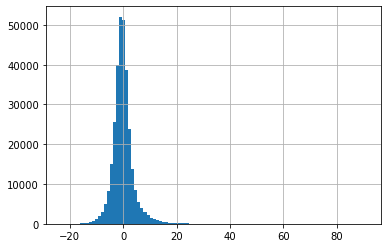

In [14]:
# histogram of the residuals
resids_and_fitted['resids'].hist(bins=100)

# Second Stage Regression

- Stage 1 of the least squares regression: $\widehat{PM}_{2.5}=\beta_0 + \beta_1 \theta_{downstream} + \beta_{2}year + \beta_{3}month + \beta_{4}county + \epsilon$
  - $\theta_{downstream}$ = Instrument = `avg_wind_alignment_cosine`. But this right hand side of the equation should also include all other exogenous (x) vars. 

- Stage 2 of the equation: $Y=\frac{\sum diagnoses}{Pop_{zipcode, 0-19}}=\delta_0 + \delta_1 \widehat{PM}_{2.5} + \delta_{2}year + \delta_{3}month + \delta_{4}county + \epsilon$


In addition to this two stage framework, also run the stage 2 regression using true pm2.5 values. So we can see how biased the coefficient is. 

In [15]:
# drop instrument, and add x_hat to the X matrix
X = X.drop(columns='avg_wind_alignment_cosine')
X['yhat_pm25'] = df['yhat_pm25']
X = X[['yhat_pm25'] + [i for i in X.columns if not re.search('yhat_pm25', i)]] # put our pred pm25 in front
X_truepm25 = pd.concat([df['pm25'], X.drop(columns='yhat_pm25')], axis = 1)

In [16]:
# fit model
fit2_hema = sm.OLS(df['y_hematopoietic'], X).fit()

# save model
if save_results:
  fit2_hema.save(os.path.join(fitted_models_path, 'stage2_ols_hematopoietic.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_hematopoietic'] = fit2_hema.fittedvalues.values

# Get residuals
resids_and_fitted_hema = pd.DataFrame({'resids': fit2_hema.resid, 'fitted': fit2_hema.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_hema).head(1))

# fit model with true pm2.5
fit2_hema_truepm25 = sm.OLS(df['y_hematopoietic'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_hema_truepm25).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  0.100868  0.066402    -0.006828     0.208565

true pm2.5:
  variable      coef  p_value  95_ci_lower  95_ci_upper
0     pm25 -0.001279  0.17311    -0.003119     0.000561


In [17]:
# fit model
fit2_vasc = sm.OLS(df['y_vasculitis'], X).fit()

# save model
if save_results:
  fit2_vasc.save(os.path.join(fitted_models_path, 'stage2_ols_vasculitis.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_vasculitis'] = fit2_vasc.fittedvalues.values

# Get residuals
resids_and_fitted_vasc = pd.DataFrame({'resids': fit2_vasc.resid, 'fitted': fit2_vasc.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_vasc).head(1))

# fit model with true pm2.5
fit2_vasc_truepm2 = sm.OLS(df['y_vasculitis'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_vasc_truepm2).head(1))

yhat pm2.5:
    variable      coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.084259  0.01914    -0.154749    -0.013768

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.002089  0.000677    -0.003293    -0.000884


In [18]:
# fit model
fit2_diab = sm.OLS(df['y_diabetes'], X).fit()

# save model
if save_results:
  fit2_diab.save(os.path.join(fitted_models_path, 'stage2_ols_diabetes.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_diabetes'] = fit2_diab.fittedvalues.values

# Get residuals
resids_and_fitted_diab = pd.DataFrame({'resids': fit2_diab.resid, 'fitted': fit2_diab.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_diab).head(1))

# fit model with true pm2.5
fit2_diab_truepm2 = sm.OLS(df['y_diabetes'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_diab_truepm2).head(1))

yhat pm2.5:
    variable    coef  p_value  95_ci_lower  95_ci_upper
0  yhat_pm25 -0.1118  0.44766     -0.40038      0.17678

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.006105  0.015245    -0.011036    -0.001174


In [19]:
# fit model
fit2_resp_cardio = sm.OLS(df['y_resp_cardio'], X).fit()

# save model
if save_results:
  fit2_resp_cardio.save(os.path.join(fitted_models_path, 'stage2_ols_resp_cardio.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_resp_cardio'] = fit2_resp_cardio.fittedvalues.values

# Get residuals
resids_and_fitted_resp_cardio = pd.DataFrame({'resids': fit2_resp_cardio.resid, 'fitted': fit2_resp_cardio.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_resp_cardio).head(1))

# fit model with true pm2.5
fit2_resp_cardio_truepm2 = sm.OLS(df['y_resp_cardio'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_resp_cardio_truepm2).head(1))

yhat pm2.5:
    variable      coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  4.352866  0.716178   -19.112949    27.818681

true pm2.5:
  variable     coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.81773  0.000064    -1.218691     -0.41677


In [20]:
# fit model
fit2_injuries = sm.OLS(df['y_injuries'], X).fit()

# save model
if save_results:
  fit2_injuries.save(os.path.join(fitted_models_path, 'stage2_ols_injuries.pickle'), remove_data=True)

# add fitted y value to our dataset
df['yhat_injuries'] = fit2_injuries.fittedvalues.values

# Get residuals
resids_and_fitted_injuries = pd.DataFrame({'resids': fit2_injuries.resid, 'fitted': fit2_injuries.fittedvalues.values})

print('yhat pm2.5:')
print(get_ols_res(fit2_injuries).head(1))

# fit model with true pm2.5
fit2_injuries_truepm2 = sm.OLS(df['y_injuries'], X_truepm25).fit()
print('\ntrue pm2.5:')
print(get_ols_res(fit2_injuries_truepm2).head(1))

yhat pm2.5:
    variable       coef   p_value  95_ci_lower  95_ci_upper
0  yhat_pm25  28.180641  0.015838     5.287337    51.073945

true pm2.5:
  variable      coef   p_value  95_ci_lower  95_ci_upper
0     pm25 -0.808092  0.000051    -1.199274     -0.41691


## All results

In [21]:
all_res_yhat = [get_ols_res(x).head(1) for x in [fit2_hema, fit2_vasc, fit2_diab, fit2_resp_cardio, fit2_injuries]]
all_res_true = [get_ols_res(x).head(1) for x in [fit2_hema_truepm25, fit2_vasc_truepm2, fit2_diab_truepm2, fit2_resp_cardio_truepm2, fit2_injuries_truepm2]]

all_res_yhat = pd.concat(all_res_yhat)
all_res_true = pd.concat(all_res_true)

print("Stage 1 results:")
print(get_ols_res(fit1).head(1))


print("\nStage 2 results:")
df_res = pd.DataFrame({
  'yvar': ['hematopoietic', 'vasculitis', 'diabetes', 'respiratory', 'injuries']
  
  ,'coef_pm25_yhat': all_res_yhat['coef'].values
  ,'pvalue_pm25_yhat': all_res_yhat['p_value'].values
  ,'ci95_lower_pm25_yhat': all_res_yhat['95_ci_lower'].values
  ,'ci95_upper_pm25_yhat': all_res_yhat['95_ci_upper'].values

  ,'coef_pm25_true': all_res_true['coef'].values
  ,'pvalue_pm25_true': all_res_true['p_value'].values
  ,'ci95_lower_pm25_true': all_res_true['95_ci_lower'].values
  ,'ci95_upper_pm25_true': all_res_true['95_ci_upper'].values
})
df_res

Stage 1 results:
                    variable      coef       p_value  95_ci_lower  95_ci_upper
0  avg_wind_alignment_cosine  0.126624  1.889755e-21     0.100532     0.152716

Stage 2 results:


,yvar,coef_pm25_yhat,pvalue_pm25_yhat,ci95_lower_pm25_yhat,ci95_upper_pm25_yhat,coef_pm25_true,pvalue_pm25_true,ci95_lower_pm25_true,ci95_upper_pm25_true
0,hematopoietic,0.100868,0.066402,-0.006828,0.208565,-0.001279,0.173110,-0.003119,0.000561
1,vasculitis,-0.084259,0.019140,-0.154749,-0.013768,-0.002089,0.000677,-0.003293,-0.000884
2,diabetes,-0.111800,0.447660,-0.400380,0.176780,-0.006105,0.015245,-0.011036,-0.001174
3,respiratory,4.352866,0.716178,-19.112949,27.818681,-0.817730,0.000064,-1.218691,-0.416770
4,injuries,28.180641,0.015838,5.287337,51.073945,-0.808092,0.000051,-1.199274,-0.416910


# Save data with results

In [22]:
if save_results:
  df.to_csv(os.path.join(data_path, 'modeling_data/modeling_data_results_2022-10-27.csv'), index=False)

# Verify the Exclusion Restriction
- Exclusion restriction: Our instrument (wind bearing) cannot be correlated to the residuals from the 2nd stage regression. 


                    wind_bearing   hema_resids   vasc_resids   diab_resids  \
wind_bearing        1.000000e+00  1.172433e-12 -1.793736e-12 -8.092257e-13   
hema_resids         1.172433e-12  1.000000e+00  2.051566e-02  5.578265e-04   
vasc_resids        -1.793736e-12  2.051566e-02  1.000000e+00  7.106334e-04   
diab_resids        -8.092257e-13  5.578265e-04  7.106334e-04  1.000000e+00   
resp_cardio_resids  1.895485e-13  6.597216e-03  5.940369e-03  6.177999e-02   
injuries_resids     1.792402e-12  4.793952e-03  2.600049e-03  3.419457e-02   

                    resp_cardio_resids  injuries_resids  
wind_bearing              1.895485e-13     1.792402e-12  
hema_resids               6.597216e-03     4.793952e-03  
vasc_resids               5.940369e-03     2.600049e-03  
diab_resids               6.177999e-02     3.419457e-02  
resp_cardio_resids        1.000000e+00     9.534865e-02  
injuries_resids           9.534865e-02     1.000000e+00  


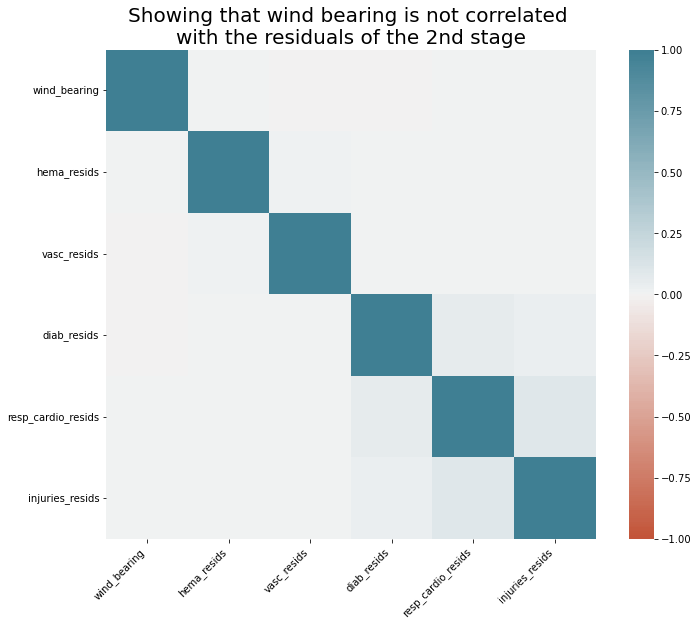

In [23]:
df_corr = pd.DataFrame({
  'wind_bearing': df['avg_wind_alignment_cosine'].values, 
  'hema_resids': resids_and_fitted_hema.resids.values,
  'vasc_resids': resids_and_fitted_vasc.resids.values, 
  'diab_resids': resids_and_fitted_diab.resids.values,
  'resp_cardio_resids': resids_and_fitted_resp_cardio.resids.values,
  'injuries_resids': resids_and_fitted_injuries.resids.values
}).corr()

# plot the results
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(df_corr, vmin=-1, center=0, vmax=1, cmap=sns.diverging_palette(20, 220, n=200), square=True)

ax.set_xticklabels(ax.get_xticklabels(), 
    rotation=45, horizontalalignment='right')
ax.set_title("Showing that wind bearing is not correlated \nwith the residuals of the 2nd stage", fontdict = {"fontsize": 20})
print('')

print(df_corr)

# First stage F-test

Run an F test with our instrument to study the impact on the pm2.5. 

In [24]:
# get data into right model form
y, X_null = dmatrices('pm25 ~ 1', data=df, return_type='dataframe')
y, X_instrument = dmatrices('pm25 ~ 1 + avg_wind_alignment_cosine', data=df, return_type='dataframe')

fit_null = sm.OLS(y, X_null).fit()
fit_instrument = sm.OLS(y, X_instrument).fit()

from statsmodels.stats.anova import anova_lm
anovaResults = anova_lm(fit_null, fit_instrument)
anovaResults

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,311162.0,1.114428e+07,0.0,NaN,NaN,NaN
1,311161.0,1.114275e+07,1.0,1526.706847,42.633231,6.612902e-11


# Distribution Plots
- These are not yet updated with the additional two diagnosis groups

The disease distributions all on one plot are too hard to visualize.

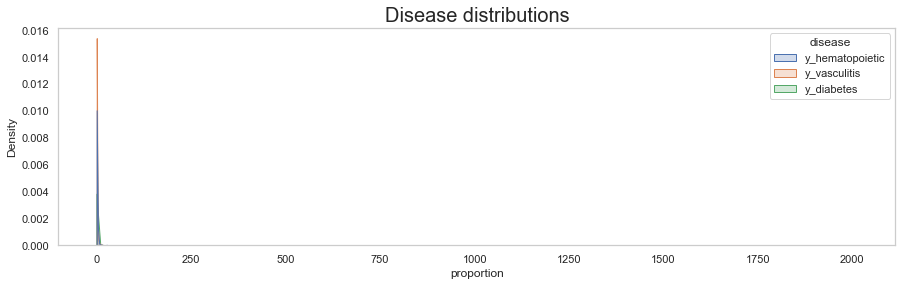

In [25]:
df_melt = pd.melt(df, 
              value_vars=['y_hematopoietic', 'y_vasculitis', 'y_diabetes'], 
              var_name='disease', value_name='proportion')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="proportion", hue='disease', bw_adjust=.8, fill=True)\
  .set_title("Disease distributions", size=20)
print('')

The plot of each disease individually is too hard to see also due to inflated 0's.

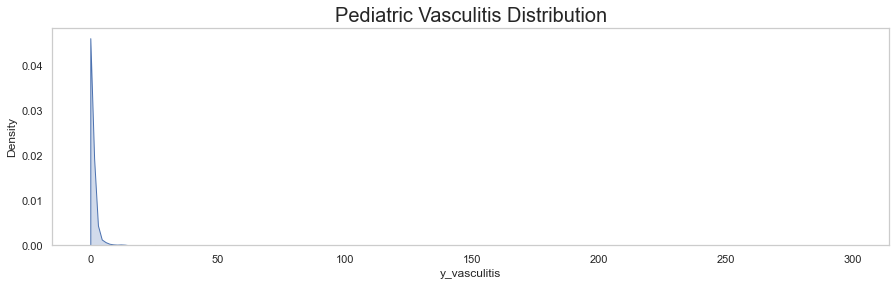

In [26]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Distribution", size=20)
print('')

Each disease distribution is heavily skewed left, with most values very close to 0. 

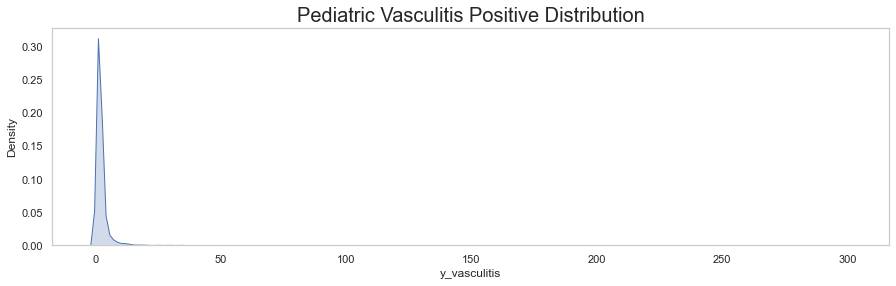

In [27]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True)\
  .set_title("Pediatric Vasculitis Positive Distribution", size=20)
print('')

Plotting the log of each disease distribution, looking at positive cases only is much easier to visualize:

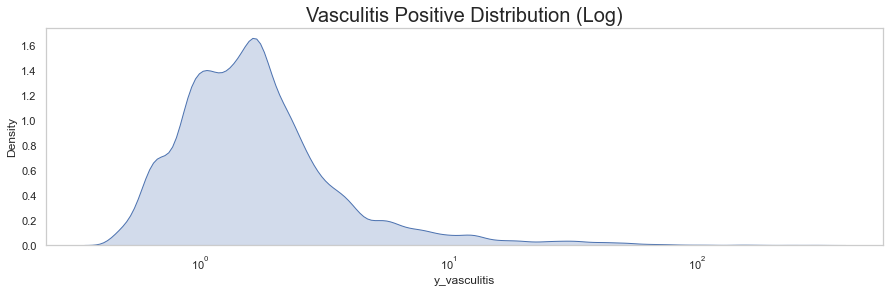

In [28]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_vasculitis']>0], x="y_vasculitis", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Vasculitis Positive Distribution (Log)", size=20)
print('')

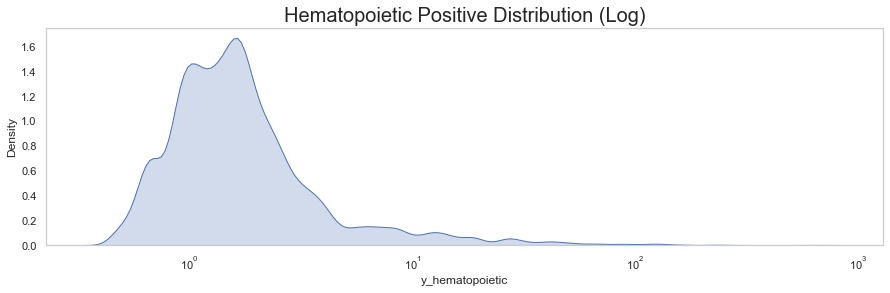

In [29]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_hematopoietic']>0], x="y_hematopoietic", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Hematopoietic Positive Distribution (Log)", size=20)
print('')

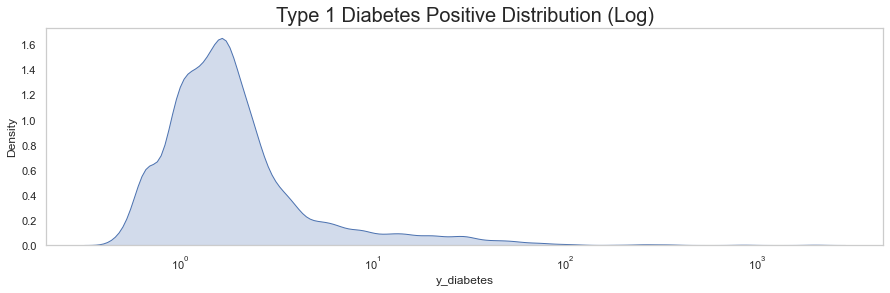

In [30]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_diabetes']>0], x="y_diabetes", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Type 1 Diabetes Positive Distribution (Log)", size=20)
print('')

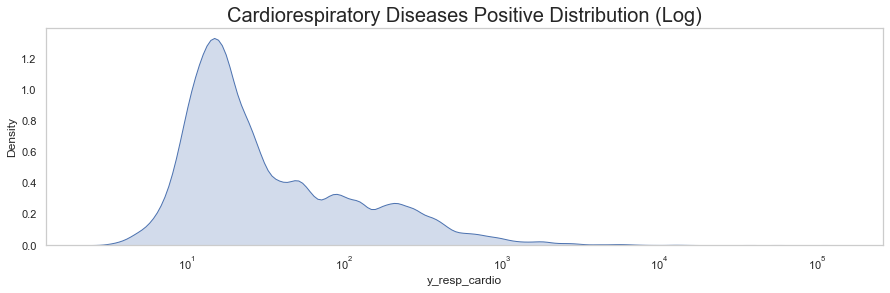

In [31]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_resp_cardio']>0], x="y_resp_cardio", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Cardiorespiratory Diseases Positive Distribution (Log)", size=20)
print('')

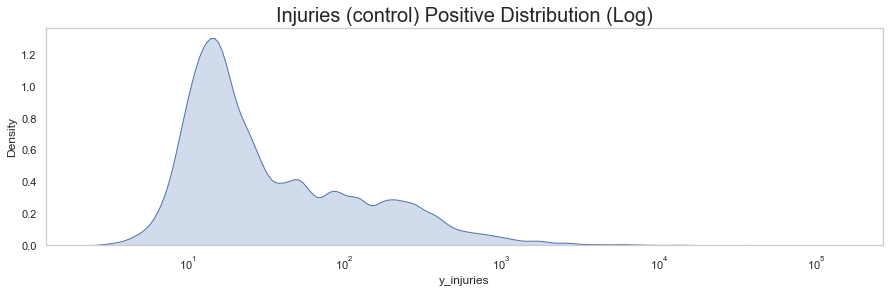

In [32]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df[df['y_injuries']>0], x="y_injuries", bw_adjust=.8, fill=True, log_scale=True)\
  .set_title("Injuries (control) Positive Distribution (Log)", size=20)
print('')

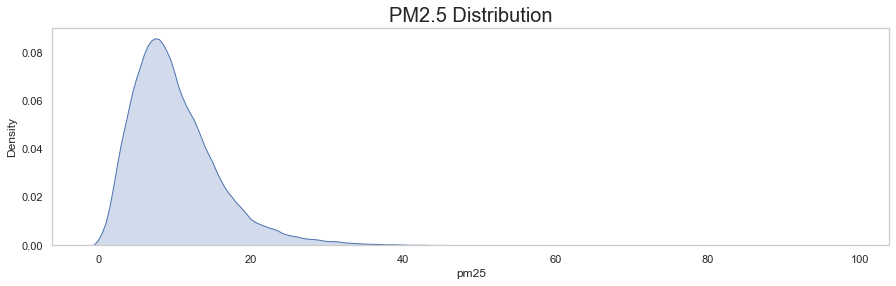

In [33]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Distribution", size=20)
print('')

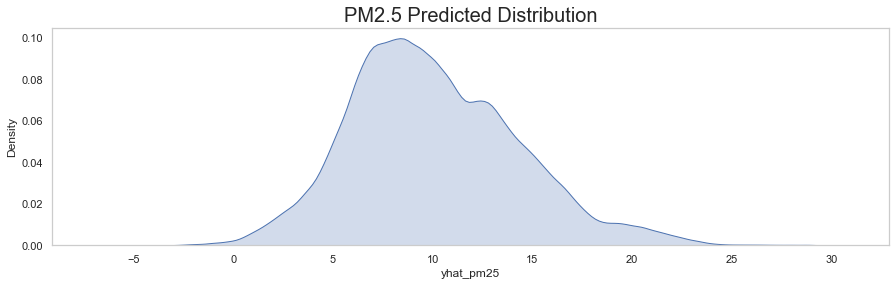

In [34]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="yhat_pm25", bw_adjust=.8, fill=True)\
  .set_title("PM2.5 Predicted Distribution", size=20)
print('')

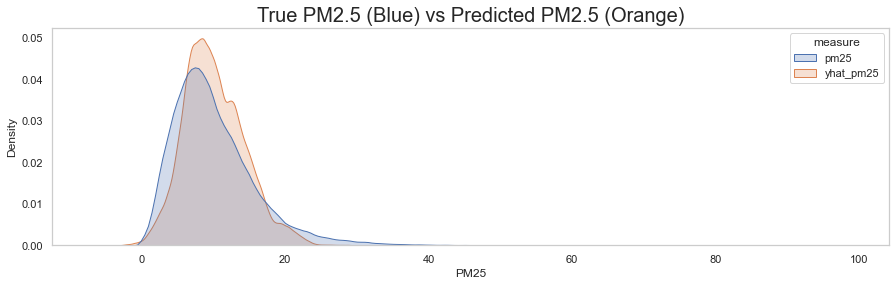

In [35]:
df_melt = pd.melt(df, 
              value_vars=['pm25', 'yhat_pm25'], 
              var_name='measure', value_name='PM25')
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df_melt, x="PM25", hue='measure', bw_adjust=.8, fill=True)\
  .set_title("True PM2.5 (Blue) vs Predicted PM2.5 (Orange)", size=20)
print('')

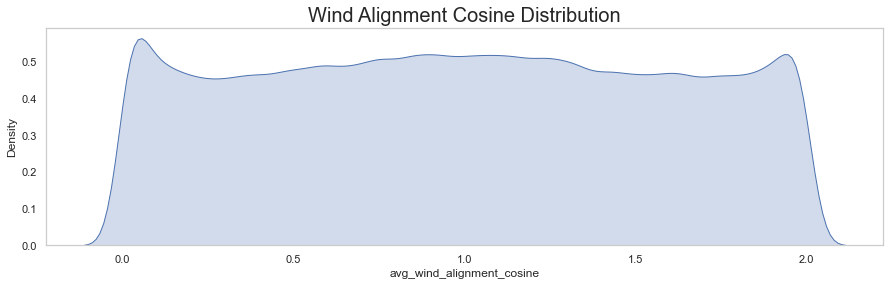

In [36]:
sns.set(rc = {'figure.figsize':(15,4)}) 
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(data=df, x="avg_wind_alignment_cosine", bw_adjust=.8, fill=True)\
  .set_title("Wind Alignment Cosine Distribution", size=20)
print('')